In [ ]:
! pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.7/104.7 KB 1.9 MB/s eta 0:00:00


In [ ]:
from torch import tensor
import torch
from numpy import random
import numpy as np
from abc import ABC, abstractmethod
import math
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

# Simple Spiking Neural Network

### Spike Codings

In [ ]:
class SpikeCoder(ABC):
  def __init__(self):
    pass

  @abstractmethod
  def encode(self, input):
    pass

  @abstractmethod
  def decode(self, input):
    pass



class RateCoder(SpikeCoder):
  def __init__(self, method='poisson', num_steps=100):
    super(SpikeCoder, self).__init__()
    self.method = method
    self.num_steps = num_steps

  # to improve
  def encode(self, input):
    result = []
    if self.method == 'poisson':
      encoder = lambda x: np.random.poisson(lam=x, size=self.num_steps)
    elif self.method == 'bernoulli': 
      encoder = lambda x: np.random.binomial(n=1, p=x, size=self.num_steps)
    for row in input:
      rows = []
      for channel in row:
        spikes = []
        for value in channel:
          spikes.append(np.clip(list(encoder(value)), 0, 1))
        rows.append(spikes)
      result.append(rows)
    return tensor(np.array(result))

  def decode(self, output):
    pass



class TemporalCoder(SpikeCoder):
  def encode(self, input):
    pass

  def decode(self, output):
    pass


### Neural Models

In [ ]:
ts = {}
sp = {}

class NeuralActivation(ABC):
  def __init__(self):
    pass

  @abstractmethod
  def _activate(self, input):
    pass



class LIF(NeuralActivation):
  def __init__(self, layer, x):
    super(LIF, self).__init__()
    spikes = []
    weights = torch.rand(len(layer), x.shape[0] * x.shape[1])
    for idx, neuron in enumerate(layer):
      spikes.append(self._activate(neuron, x, weights[idx]))
      ts[idx] = neuron.spikes
      sp[idx] = neuron.history

  def _activate(self, neuron, x, weight):
    spikes_out = []
    x = torch.flatten(x, start_dim=0, end_dim=1)
    x = torch.squeeze(x)
    x = x.permute(1, 0)
    print(x)
    for step, spikes in enumerate(x):
      U_mem = neuron.potential
      # U_mem = U_mem + (5 / neuron.tau) * (- U_mem + sum(spikes) * neuron.resistance) - (U_mem > neuron.threshold) * neuron.threshold
      # U_mem = U_mem * math.exp(- timestep / neuron.tau) + sum(spikes)
      U_mem = np.dot(spikes, weight) * neuron.resistance + U_mem * math.exp(- 1 / neuron.tau)
      if U_mem > neuron.threshold:
        neuron.reset(step)
      else:
        neuron.set_potential(U_mem, step)


### Spiking Neural Network

In [ ]:
class SpikingNeuron():
  def __init__(self):
    self.potential = 0
    self.resistance = 30
    self.tau = 10
    self.threshold = 1000
    self.spike_value = 80
    self.spikes = []
    self.history = []
  
  def reset(self, timestep):
    self.spike(timestep)
    self.potential = 0
    self.history.append(self.potential)
    self.spikes.append(timestep)
  
  def set_potential(self, potential, timestep):
    self.potential = potential
    self.history.append(self.potential)
    self.spikes.append(timestep)
  
  def spike(self, timestep):
    self.history.append(self.spike_value)
    self.spikes.append(timestep)
  
  def get_spikes(self, timesteps):
    spikings = [int(idx in self.spikes) for idx in range(timesteps)]
    return spikings


In [ ]:
class SpikingNetwork():
  def __init__(self, input_dim=(28, 28, 1), hidden_dim=1, output_dim=1, encoder=RateCoder()):
    self.encoder = encoder
    self.hidden_layer = self._linear(input_dim, hidden_dim)
    # self.network = []

  def forward(self, x):
    x = self._rate_encode(x)
    LIF(self.hidden_layer, x)
    x = [neuron.get_spikes(self.encoder.num_steps) for neuron in self.hidden_layer]
    return x

  def _linear(self, input_dim, output_dim):
    layer = [SpikingNeuron() for dim in range(output_dim)]
    # self.network.append(layer)
    return layer

  def _rate_encode(self, input):
    return self.encoder.encode(input)

  def _temporal_encode(self):
    pass
    

# Preparing the dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True)
image, label = next(iter(trainloader))

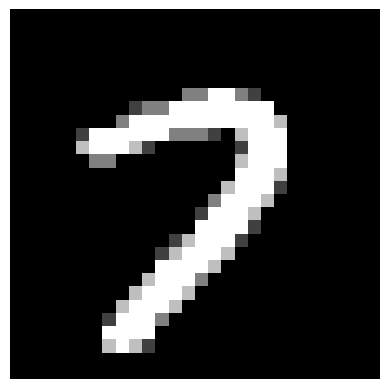

In [ ]:
def show_image(image):
  plt.axis("off")
  plt.imshow(image.squeeze(), cmap="gray")
  plt.show()
  
show_image(image)

### Encoding Tests

In [ ]:
encoder = RateCoder(method='bernoulli')
image = image.squeeze()
image = image.reshape((image.shape[0], image.shape[1], 1))
output = encoder.encode(image)

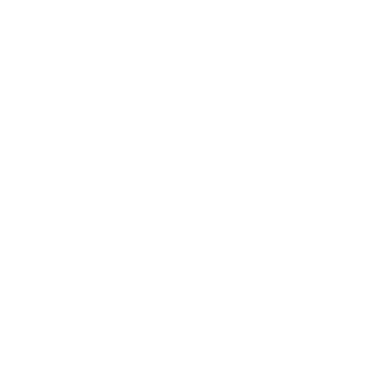

In [ ]:
out = output.squeeze()
out = out.permute(2, 0, 1)
fig, ax = plt.subplots()
anim = splt.animator(out, fig, ax)
HTML(anim.to_html5_video())

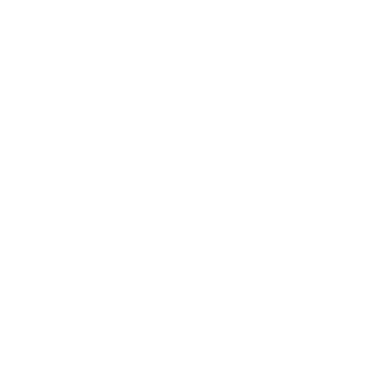

In [ ]:
encoder = RateCoder()
output = encoder.encode(image)
out = output.squeeze()
out = out.permute(2, 0, 1)
fig, ax = plt.subplots();
anim = splt.animator(out, fig, ax);
HTML(anim.to_html5_video())

# Building the Neural Network

In [ ]:
# length of the spike trains
num_steps = 50
hidden_dim = 3
output_dim = 1
image, label = next(iter(trainloader))
image = image.squeeze()
image = image.reshape((image.shape[0], image.shape[1], 1))

encoder = RateCoder(method='poisson', num_steps=num_steps)
model = SpikingNetwork(encoder=encoder, hidden_dim=hidden_dim, output_dim=output_dim)
output = model.forward(image)
for idx, out in enumerate(output):
  print(f'The neuron {idx} has spiked {sum(out)} times over {encoder.num_steps}')


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
The neuron 0 has spiked 50 times over 50
The neuron 1 has spiked 50 times over 50
The neuron 2 has spiked 50 times over 50


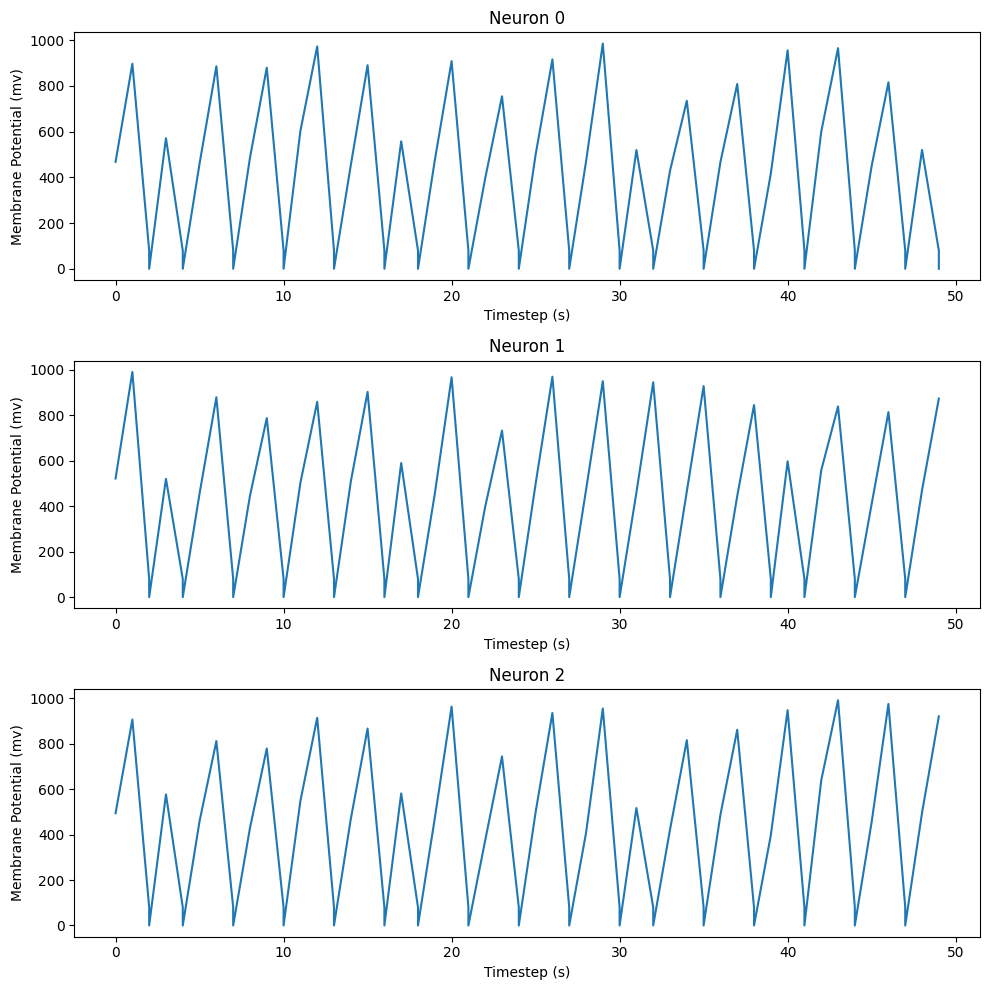

In [ ]:
# neurons potential visualization
fig, axs = plt.subplots(len(output), 1)
for idx in range(len(output)):
  axs[idx].plot(np.array(ts[idx]).flatten(), np.array(sp[idx]).flatten())
  axs[idx].set_xlabel('Timestep (s)')
  axs[idx].set_ylabel('Membrane Potential (mv)')
  axs[idx].set_title(f'Neuron {idx}')
  fig.set_figheight(10)
  fig.set_figwidth(10)
  fig.tight_layout()
